# Analysis of differential expression across conditions

* Temperature: 10, 18, 25, 34
* Lighting: Dark, Light

__NOTES__:

1. So far I have computed DE among all samples disregarding effect of day cycle. I would need to compute DE between light and dark conditions, as well as DE for temperature for the two independent data sets (light, dark)
2. Regarding the two effects, I could find genes:

Condition | Temp (10 -> 34) 
--- | ---
Light | (+, -) 
Dark | (+, -) 

Hence, would be interesting to cluster genes based on the DE pattern, i.e., those which correlate with temperatur in the same manner under light or dark and those that differ...

3. Need also to establish which condition generates more variance: lighting or temperature?
4. GEMs of marine bacteria: https://www.sciencedirect.com/science/article/pii/S1874778717300508?via%3Dihub#bb0165
5. GEM reconstrution tools: https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1769-1
6. Use Clust to cluster genes with significant DE among temperatures with similar patterns: https://github.com/BaselAbujamous/clust 

References:
* Rsubread: https://academic.oup.com/nar/article/47/8/e47/5345150
* DeSeq2: https://genomebiology.biomedcentral.com/articles/10.1186/s13059-014-0550-8
* Clust: https://genomebiology.biomedcentral.com/articles/10.1186/s13059-018-1536-8
* BRENDA: https://academic.oup.com/nar/article/49/D1/D498/5992283
* eQuilibrator: https://academic.oup.com/nar/article/40/D1/D770/2903458

In [138]:
import pandas as pd
import numpy as np
import os
# from diffexpr.py_deseq import py_DESeq2
# from rpy2.rinterface_lib.callbacks import logger as rpy2_logger
# from rpy2.robjects import Formula
# import logging
# rpy2_logger.setLevel(logging.ERROR)
# from subprocess import call
from matplotlib import pyplot as plt
import Dokdonia_code as Dc
%matplotlib inline


# os.path.expanduser(path) expands the path to the user's home directory
# os.path.join(path1,*path2*,...) joins path elements with the appropriate separator
# os.sep gives the OS dependent path separator (/ for Linux/Unix, \ for Windows)
# os.getcwd() gives the current working directory
# os.path.abspath(path) gives the OS dependent absolute path of a given path

In [140]:
os.path.join(os.getcwd(),'Data/hola.txt')

'/home/robaina/Documents/Proyecto_rodopsina/Data/hola.txt'

## Parse GBK file

In [12]:
gbk = Dc.GenomeGBK('Data/DokdoniaMED134.gbk')
gbk.meta

{'organism': ['Dokdonia sp. MED134'],
 'mol_type': ['genomic DNA'],
 'strain': ['MED134'],
 'isolation_source': ['collected at a depth of 1 meter; isolated by plating on solid media'],
 'db_xref': ['taxon:313590'],
 'country': ['Mediterranean Sea']}

In [2]:
# Loading counts and removing genes with low read counts across samples
min_count = 10

counts = pd.read_csv('Data/DokdoniaCounts.csv', index_col=0)
conditions = [name.split('.sam')[0] for name in counts.columns]
counts.columns = conditions
counts = counts[(counts > min_count).all(1)]
counts.reset_index(level=0, inplace=True)
# ax = counts.sum().plot.bar(figsize=(15, 10))
counts.head()

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


,index,D_10_R1,D_10_R2,D_10_R3,D_18_R1,D_18_R2,D_18_R3_T1,D_18_R3,D_18_R4,D_25_R1,...,L_25_R1,L_25_R2,L_25_R3,L_34_R1,L_34_R2,L_34_R3,L_34_R4_T1,L_34_R4_T2,L_34_R4_T3,L_34_R4
0,MED134_07389,12973,11426,13251,30624,30618,25566,41014,22449,53840,...,39444,41721,37020,39662,30983,27280,43105,44946,39311,57834
1,MED134_07384,1557,1555,1552,4160,4385,3383,5588,2940,7550,...,5419,5536,5318,5396,4751,4285,5108,4924,4503,7818
2,MED134_07379,3400,3319,3273,7218,7903,6315,9539,5040,13268,...,9089,9016,8529,10179,7617,7207,9484,8837,8743,13827
3,MED134_07374,1987,2124,1404,3509,3772,2846,4337,2602,4607,...,3586,3594,3488,4158,3096,2623,3818,3792,3538,5323
4,MED134_07369,2087,2010,2111,3774,3809,2921,4486,2901,4668,...,3705,4158,3760,5518,3563,2713,3679,3543,3356,5150


## Analysis of differential expression

We compare expression across temperature and between light and dark conditions.

## DE light vs dark across temperatures

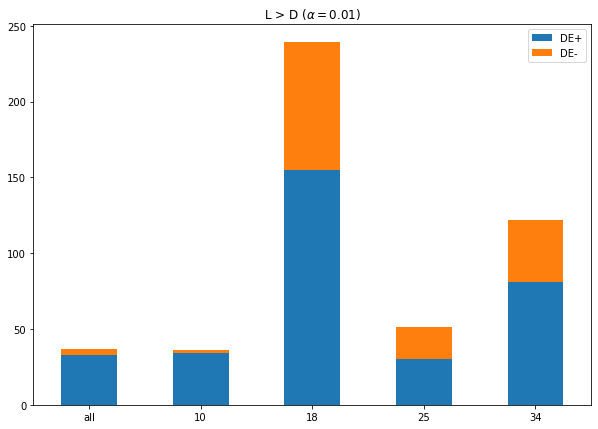

In [97]:
p_value_cutoff = 1e-2

# DE light vs dark across temperatures
L_D_res, L_D_stats = {}, {}
L_D_res['all'], L_D_stats['all'] = Dc.runDEtest(counts, test='Wald', alpha=p_value_cutoff,
                                                formula='~ lighting')
# L vs D for each temperature
for T in meta.temperature.unique():
    T = str(T)
    counts_T = counts[counts.filter(regex=f'{T}|index').columns]    
    L_D_res[T], L_D_stats[T] = Dc.runDEtest(counts_T, test='Wald', alpha=p_value_cutoff,
                                            formula='~ lighting')
# Plot stats
ax = pd.DataFrame(L_D_stats).transpose().plot.bar(
    stacked=True, title=f'L > D ($\\alpha={p_value_cutoff}$)', figsize=(10, 7), rot=0)

In [18]:
# Proteins
np.unique([gbk.getGeneInfo(gene_id)['product'][0] for gene_id in res[res.log2FoldChange > 0].index])

array(['ABC transporter ATP-binding protein', 'ABC1 family protein',
       'ATP-dependent protease La (LON)',
       'DNA mismatch repair protein MutS',
       'DNA photolyase/cryptochrome, animal cryptochrome and (6-4) photolyase subfamily',
       'GTP cyclohydrolase I', 'HlyD family secretion protein',
       'beta-carotene hydroxylase', 'cryptochrome, DASH family',
       'deoxyribodipyrimidine photo-lyase, class I',
       'deoxyribodipyrimidine photolyase-related protein',
       'ferrochelatase', 'fungalysin metallopeptidase (M36)',
       'glycine dehydrogenase', 'hypothetical protein',
       'peptide-methionine (S)-S-oxide reductase',
       'phytoene dehydrogenase', 'phytoene synthase',
       'putative cell adhesion protein',
       'radical SAM superfamily protein', 'rhodopsin',
       'sensor of blue-light using FAD', 'short chain dehydrogenase',
       'transcription regulator, MerR family'], dtype='<U79')

## DE on multiple comparisons
See https://hbctraining.github.io/DGE_workshop/lessons/08_DGE_LRT.html
Fold changes here aren't meaningful.

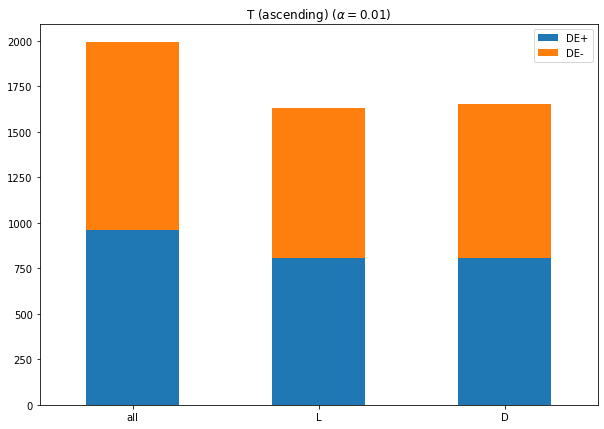

In [108]:
# Do not discriminate between Light and Dark conditions
T_res, T_stats = {}, {}
T_res['all'], T_stats['all'] = Dc.runDEtest(counts, test='LRT', alpha=p_value_cutoff,
                                            formula='~ temperature', reduced_formula='~ 1')

# Discriminate between Light and Dark conditions
for L in ['L', 'D']:
    counts_L = counts[counts.filter(regex=f'{L}|index').columns]    
    T_res[L], T_stats[L] = Dc.runDEtest(counts_L, test='LRT', alpha=p_value_cutoff,
                                        formula='~ temperature', reduced_formula='~ 1')
    
# Plot stats
ax = pd.DataFrame(T_stats).transpose().plot.bar(
    stacked=True, title=f'T (ascending) ($\\alpha={p_value_cutoff}$)', figsize=(10, 7), rot=0)

## Gene clustering based on expression pattern
We will employ _clust_ to cluster significant DE genes into groups of similar expression pattern across conditions. Let's first generate the tsv file required by _Clust_

In [124]:
tpm = pd.read_csv('Data/tpm_counts.csv', index_col=0)
tpm.index.name = 'ID'
tpm.columns = conditions
tpm.head()

,D_10_R1,D_10_R2,D_10_R3,D_18_R1,D_18_R2,D_18_R3_T1,D_18_R3,D_18_R4,D_25_R1,D_25_R2,...,L_25_R1,L_25_R2,L_25_R3,L_34_R1,L_34_R2,L_34_R3,L_34_R4_T1,L_34_R4_T2,L_34_R4_T3,L_34_R4
ID,,,,,,,,,,,,,,,,,,,,,
MED134_07389,126.651810,103.199290,132.954350,207.076817,186.093462,230.692835,232.104483,217.039083,319.508620,287.121249,...,309.890336,332.917481,319.950739,279.889139,329.788952,298.880372,360.335351,386.297760,364.639362,342.590660
MED134_07384,93.133592,86.051736,95.409665,172.349350,163.294159,187.033790,193.755730,174.154632,274.518258,245.054704,...,260.851290,270.660405,281.605927,233.308269,309.844950,287.640881,261.623569,259.296074,255.916424,283.749242
MED134_07379,98.558447,89.008953,97.508810,144.920691,142.623218,169.195430,160.286964,144.682310,233.790545,199.430055,...,212.025033,213.618935,218.871276,213.285093,240.735725,234.450684,235.404478,225.517345,240.798561,243.200355
MED134_07374,216.411361,214.016968,157.156450,264.706216,255.762687,286.495249,273.811718,280.646379,305.004991,328.141969,...,314.303035,319.941937,336.305821,327.346067,367.641724,320.599267,356.062594,363.588951,366.115816,351.770941
MED134_07369,287.031906,255.749791,298.386295,359.507705,326.138456,371.312544,357.641093,395.116727,390.251982,431.863528,...,410.064372,467.415509,457.795258,548.567247,534.275427,418.735291,433.257163,428.981967,438.538927,429.770161


In [162]:
workdir = os.path.join(os.getcwd(),'Data')
res_id = 'PRUEBA'
DE_TPM = tpm[tpm.index.isin(T_res['all'].index)]
clusters = getGeneClusters(DE_TPM, path_to_wd=workdir, 
                              out_dir=os.path.join(os.getcwd(),f'Data/{res_id}'),
                              cluster_tightness=1)

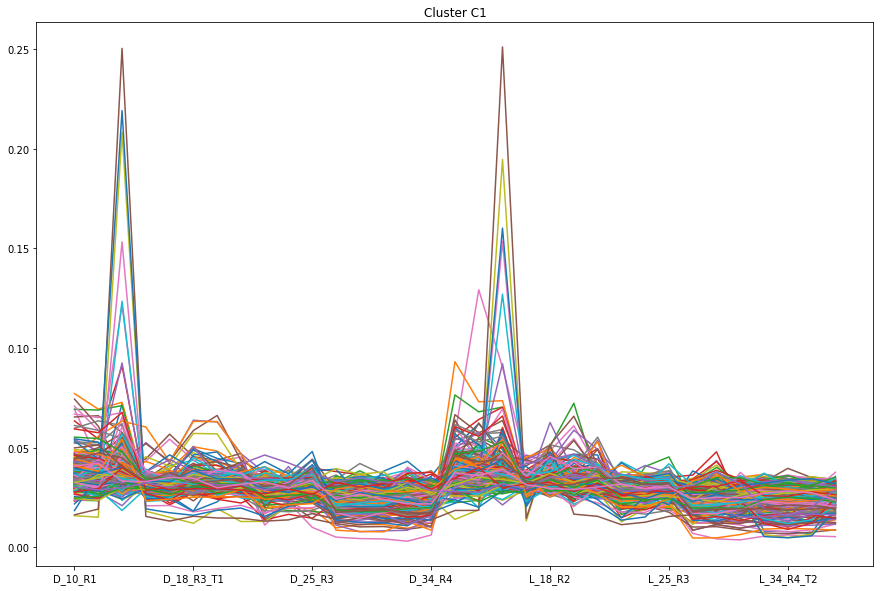

In [161]:
# Tightness < 1 gives 2 clusters, 1 gives 4 clusters
clusters.keys()
pdata = tpm.div(tpm.sum(axis=1), axis=0)
cluster_id = 'C1'
ax = pdata[pdata.index.isin(clusters[cluster_id])].transpose().plot(
    legend=False, figsize=(15, 10), title=f'Cluster {cluster_id}')

In [ ]:
# Write txt of meta data on replicates
if not os.path.exists('Data/clust_replicates.txt'):
    conds = np.unique([s[:4] for s in counts.columns[1:]])
    with open('Data/clust_rep.txt', 'a+') as file:
        for cond in conds:
            reps = ",".join(list(counts.filter(regex=f'{cond}').columns))
            txt_s = f'clust_input.tsv, {cond}, {reps}\n'
            print(txt_s)
            file.write(txt_s)
            
# Write tsv of TPM values containing significant DE genes
tpm[tpm.index.isin(res.index)].to_csv('/Data/clust_input.tsv', sep='\t')

# Call Clust
workDir = 'C:/Users/tinta/OneDrive/Documents/Projects/Proyecto_rodopsina/Data'
s_code = call(['clust', f'{workDir}/clust_input.tsv'], cwd=workDir)

In [7]:
# Ploting genes from clusters
clusters = pd.read_csv('Data/Results_14_Mar_21/Clusters_Objects.tsv', sep='\t', header=1)
clusters = {f'C{i}': clusters.iloc[:,i].dropna().values for i in range(2)}
pdata = tpm.div(tpm.sum(axis=1), axis=0)

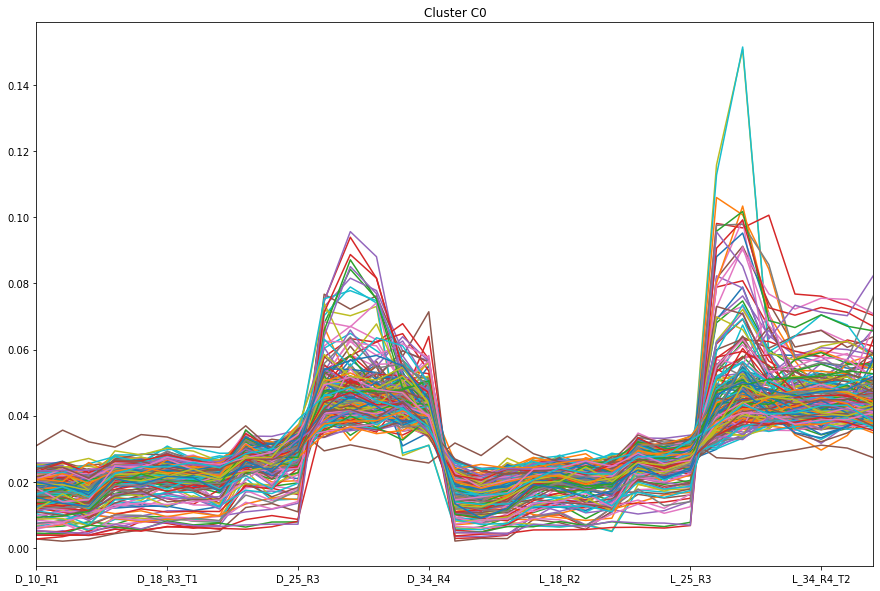

In [67]:
# Ploting genes from clusters
ax = pdata[pdata.index.isin(clusters['C0'])].transpose().plot(
    legend=False, figsize=(15, 10), title='Cluster C0')

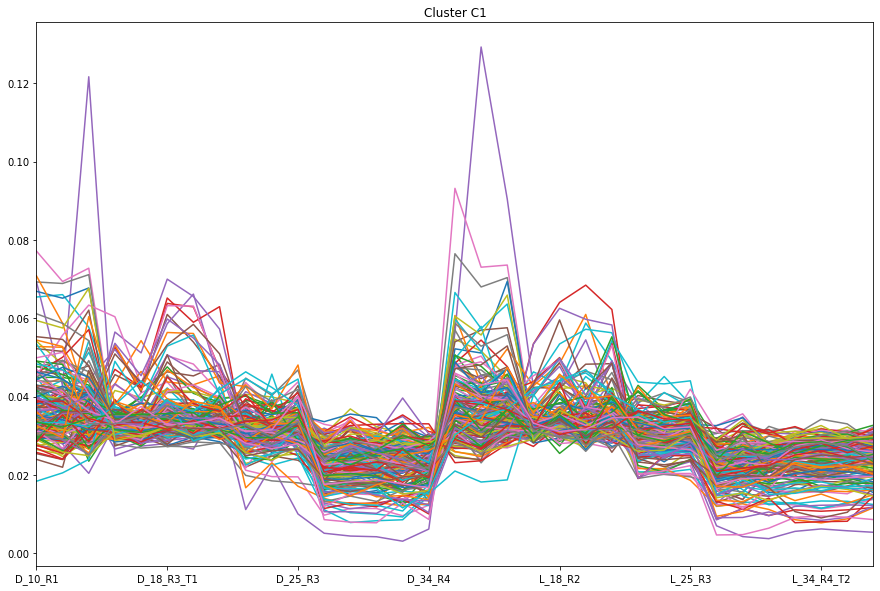

In [68]:
ax = pdata[pdata.index.isin(clusters['C1'])].transpose().plot(
    legend=False, figsize=(15, 10), title='Cluster C1')

## Do we have enzymes in the clusters?


In [20]:
ec_genes_C0 = np.unique([gbk.getGeneInfo(gene_id)['product'][0] for gene_id in clusters['C0'] if gbk.has_EC_number(gene_id)])
print(ec_genes_C0)

['2-amino-3-ketobutyrate CoA ligase' '2-dehydro-3-deoxygluconokinase'
 'D-alanyl-D-alanine carboxypeptidase' 'DNA gyrase subunit B'
 'DNA polymerase III subunit gamma/tau' 'DNA polymerase III, beta subunit'
 'DNA topoisomerase IV subunit B' 'DNA-directed DNA polymerase'
 'N-acetylmuramoyl-L-alanine amidase'
 'UDP-N-acetylglucosamine1- carboxyvinyltransferase'
 'UDP-N-acetylmuramoylalanyl-D-glutamyl-2, 6-diaminopimelate-D-alanyl-D-alanyl ligase'
 'alpha-acetolactate decarboxylase' 'alpha-amylase' 'biotin synthase'
 'catalase/peroxidase HPI' 'coproporphyrinogen III oxidase'
 'dihydrofolate reductase' 'glucose-6-phosphate isomerase'
 'isocitrate dehydrogenase' 'metallopeptidase family M24'
 'oligo-1,6-glucosidase'
 'ribonucleoside-diphosphate reductase small chain'
 'serine O-acetyltransferase' 'serine hydroxymethyltransferase'
 'superoxide dismutase' 'tetrahydrofolate synthase' 'thymidylate synthase'
 'two-component system sensor histidine kinase']


In [23]:
ec_genes_C1 = np.unique([gbk.getGeneInfo(gene_id)['product'][0] for gene_id in clusters['C1'] if gbk.has_EC_number(gene_id)])
print(ec_genes_C1)

['8-amino-7-oxononanoate synthase' 'DNA topoisomerase I'
 'DNA-directed RNA polymerase beta chain' 'GTP cyclohydrolase I'
 'IMP dehydrogenase' 'L-serine deaminase' 'adenylate kinase'
 'alanyl-tRNA synthetase' 'crossover junction endodeoxyribonuclease RuvC'
 'cytidine deaminase' 'diacylglycerol kinase' 'glycogen synthase'
 'kynureninase' 'lysyl-tRNA synthetase'
 'oxygen-independent coproporphyrinogen III oxidase, putative'
 'peptidyl-tRNA hydrolase' 'prephenate dehydratase'
 'prolyl oligopeptidase' 'prolyl-tRNA synthetase'
 'propionyl-CoA carboxylase beta chain' 'pseudouridylate synthase'
 'riboflavin biosynthesis protein RibF'
 'ribose-phosphate pyrophosphokinase'
 'saccharopine dehydrogenase (NADP+, L-glutamate forming)'
 'shikimate dehydrogenase'
 'site-specific DNA-methyltransferase (adenine-specific)'
 'sulfate permease' 'tRNA pseudouridine synthase A'
 'tRNA-guanine transglycosylase'
 'two-component system sensor histidine kinase'
 'uroporphyrinogen-III synthase']


## Taking a look at selected genes with high log2 fold change (34º vs 10º)

Evaluating gene: MED134_08511


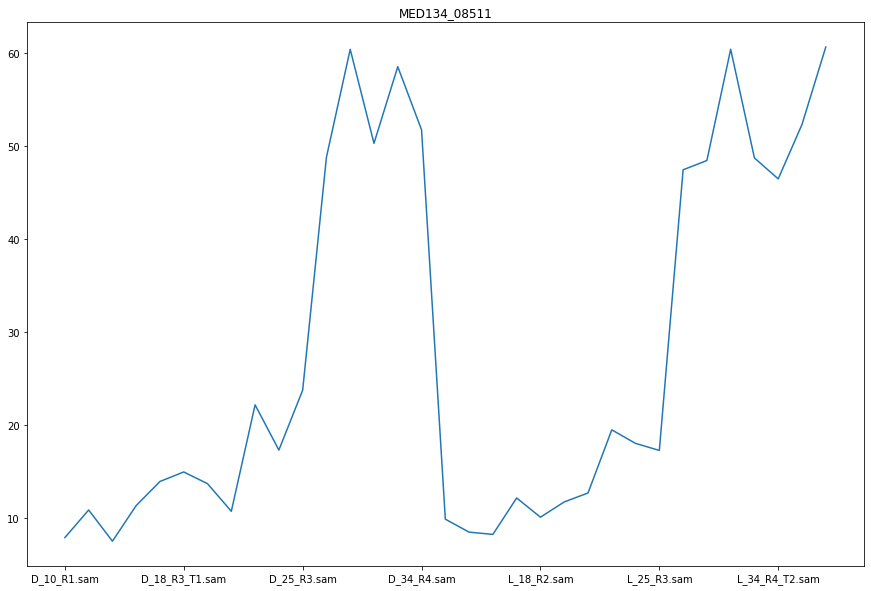

In [184]:
gene_id = pos_corr_genes[30]
print(f'Evaluating gene: {gene_id}')
ax = tpm.loc[gene_id].plot(legend=False, figsize=(15, 10), title=gene_id)

Evaluating gene: MED134_05724


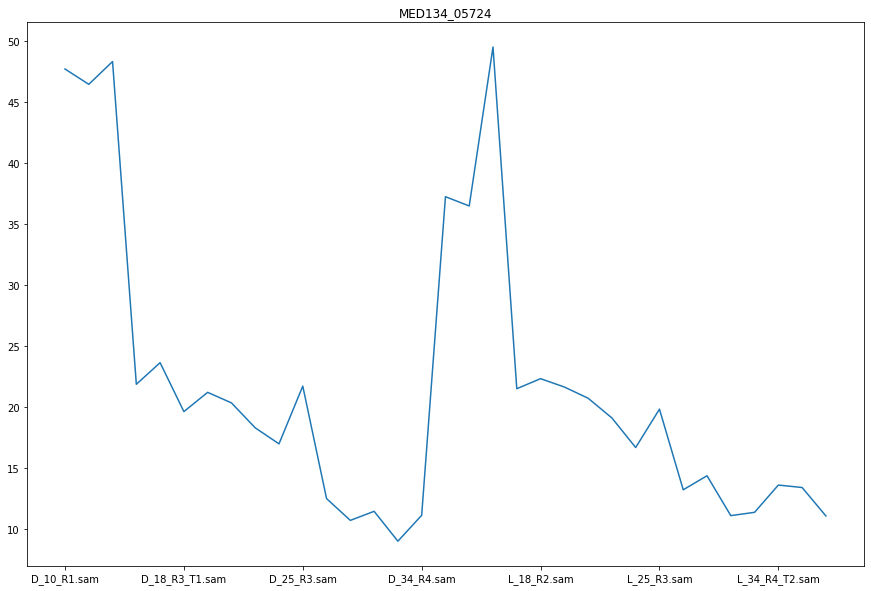

In [52]:
gene_id = neg_corr_genes[5]
print(f'Evaluating gene: {gene_id}')
ax = tpm.loc[gene_id].plot(legend=False, figsize=(15, 10), title=gene_id)

In [255]:
gene_id = 'MED134_07089' # THe EC corresponds to adenylate cyclase... however protein EAQ40501.1 has no annotation 
gbk.getGeneInfo(gene_id)

{'locus_tag': ['MED134_07089'],
 'EC_number': ['4.6.1.1'],
 'codon_start': ['1'],
 'transl_table': ['11'],
 'product': ['sensor of blue-light using FAD'],
 'protein_id': ['EAQ40501.1'],
 'translation': ['MYTICYLSKVSPHLTETQIQEIFDHTYAQNNKKGICGILLHTMGNFFQVLEGDEAYLTDLYENRIKKDPRHHSIFEVIHKEGSDPVFTSYSSRFLTIEDSDALNDIKTYVKKHAVVSSTSDKIARLLNTVEMLTY'],
 'location': FeatureLocation(ExactPosition(67655), ExactPosition(68063), strand=-1)}

In [260]:
# Trying out ec finder (Pyruvate kinase) [CO2] in solution higher with cold
gbk.getEnzymeGene('2.7.1.40')

['MED134_09046']

Evaluating gene: MED134_09046


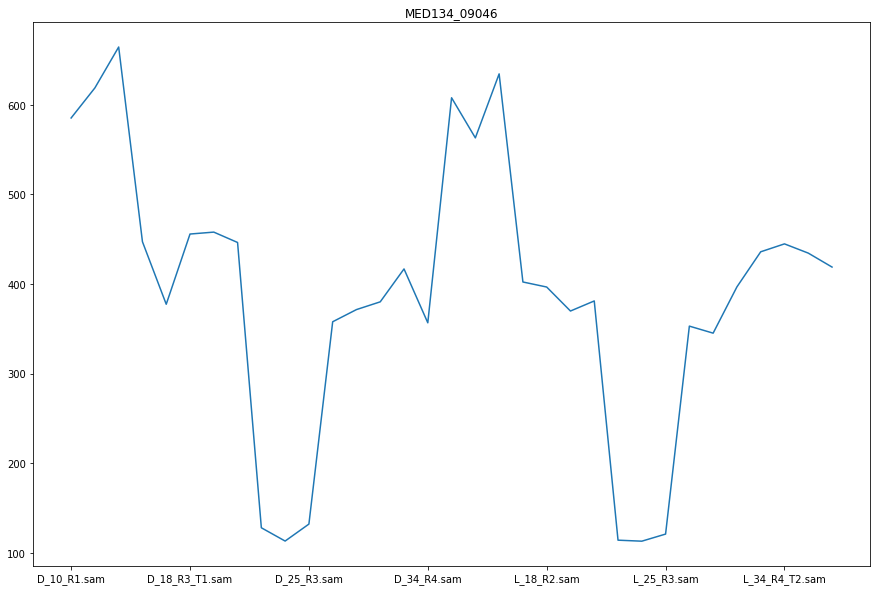

In [261]:
gene_id = gbk.getEnzymeGene('2.7.1.40')[0]
print(f'Evaluating gene: {gene_id}')
ax = tpm.loc[gene_id].plot(legend=False, figsize=(15, 10), title=gene_id)

In [265]:
res[gene_id] # Weird that this one is not among DE... perhaps because only comparing 34 vs 10 degress...

In [11]:
# This part to be used with pair-wise comparisons (no LRT)
neg_corr_genes = res[res.log2FoldChange < -1].index.tolist()
pos_corr_genes = res[res.log2FoldChange > 1].index.tolist()
print(f'There are: {len(pos_corr_genes)} positive genes and {len(neg_corr_genes)} negative')

There are: 0 positive genes and 0 negative


## Finding metabolic genes (EC number) among DE

In [191]:
met_pos_genes = [gene_id for gene_id in pos_corr_genes if gbk.has_EC_number(gene_id)]
met_neg_genes = [gene_id for gene_id in neg_corr_genes if gbk.has_EC_number(gene_id)]
print(f'There are: {len(met_pos_genes)} positive genes with EC and {len(met_neg_genes)} negative')

There are: 22 positive genes with EC and 42 negative


In [194]:
# Which enzymes are negatively correlated with temperature?
print([gbk.getGeneInfo(gene_id)['product'][0] for gene_id in met_neg_genes])

['6-phosphofructokinase', 'glyceraldehyde-3-phosphate dehydrogenase A', 'phosphoribosylformylglycinamidine synthase', 'imidazole glycerol phosphate synthase subunit HisF', 'methylmalonyl-CoA mutase', 'glutamate-ammonia ligase', 'propionyl-CoA carboxylase beta chain', 'two-component system sensor histidine kinase', 'DNA-directed RNA polymerase beta chain', 'prephenate dehydratase', 'tRNA-guanine transglycosylase', 'NADH dehydrogenase', 'O-acetylhomoserineaminocarboxypropyltransferase', 'inorganic pyrophosphatase', 'ATP-dependent Clp protease proteolytic subunit', 'FKBP-type peptidyl-prolyl cis-transisomerase', 'glycogen synthase', 'ribose-phosphate pyrophosphokinase', '3-oxoacid CoA-transferase, B subunit', '3-oxoacid CoA-transferase, A subunit', 'pyruvate kinase', 'amidophosphoribosyltransferase', 'choline dehydrogenase', 'glutamate dehydrogenase', 'sulfate permease', 'saccharopine dehydrogenase (NADP+, L-glutamate forming)', 'crossover junction endodeoxyribonuclease RuvC', 'oxygen-ind

In [195]:
# Which enzymes are positively correlated with temperature?
print([gbk.getGeneInfo(gene_id)['product'][0] for gene_id in met_pos_genes])

['sensor of blue-light using FAD', 'oligo-1,6-glucosidase', 'hydroxymethylglutaryl-CoA lyase', 'pyruvate carboxylase', 'glyceraldehyde-3-phosphate dehydrogenase A', 'isocitrate lyase', 'malate synthase', 'two-component system sensor histidine kinase', 'Asp/Glu/hydantoin racemase', 'D-amino acid dehydrogenase small subunit', 'proline racemase', 'catalase/peroxidase HPI', 'peptide-methionine (S)-S-oxide reductase', 'phosphoenolpyruvate carboxykinase (ATP)', '2-dehydro-3-deoxygluconokinase', 'alginate lyase precursor', 'alginate lyase', 'ribonuclease HII', 'pyrimidine operon attenuation protein / uracil phosphoribosyltransferase', 'two-component system sensor histidine kinase', 'sulfate adenylyltransferase subunit 2', 'sulfate adenylyltransferase subunit 1']


## Connecting expression to metabolism
* Identify genes coding for enzymes
* Get thermodynamic information for the reaction (equilibrator)
These would give an idea of which reactions may be happening as well as the direction of flow

In [2]:
from brendapyrser import BRENDA
brenda_path = 'C:/Users/tinta/OneDrive/Documents/Projects/BRENDA/data/brenda_download.txt'
brenda = BRENDA(brenda_path)
brenda

Number of Enzymes,7558
BRENDA copyright,"Copyrighted by Dietmar Schomburg, Techn. University Braunschweig, GERMANY. Distributed under the License as stated at http:/www.brenda-enzymes.org"
Parser version,0.1.0
Author,"Semidán Robaina Estévez, 2020"


In [3]:
brenda.reactions.get_by_id('2.7.1.40')

Enzyme identifier,2.7.1.40
Name,Pyruvate kinase
Systematic name,ATP:pyruvate 2-O-phosphotransferase
Reaction type,Phospho group transfer
Reaction,ATP + pyruvate <=> ADP + phosphoenolpyruvate


# Notes on possible errors in annotation
1. MED134_07089: The EC number corresponds to [adenylate cyclase](https://www.brenda-enzymes.org/enzyme.php?ecno=4.6.1.1) however protein [EAQ40501.1](https://string-db.org/network/313590.MED134_07089) isn't annotated, and the product description is "sensor of blue light using FAD". After searching for EC number ('4.6.1.1') I found another gene: MED134_03369, which seems to be the true adenylate cyclase!.